In [1]:
import wisps
import splat
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import numpy as np
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
lf=wispsim.LUMINOSITY_FUCTION
lfdes=wispsim.DES_LUMINOSITY_FUCTION
maglimits=wispsim.MAG_LIMITS
pnts=wispsim.OBSERVED_POINTINGS
candidates=wisps.datasets['candidates']

In [3]:
spgrid=np.arange(20., 37.)

In [4]:
#spgrid

In [5]:
vols=[]
for spt in spgrid:
    vm=[]
    for pntg in pnts:
        vm.append(pntg.volume[spt])
    vols.append(vm)

In [6]:
vols=np.array(vols)

In [7]:
#wispsim.SOLID_ANGLE

In [8]:
volumes=np.nansum(vols, axis=1)*wispsim.SOLID_ANGLE

In [9]:
other_lfs=wispsim.simulate_spts()

In [10]:
def drop_nan(x):
    x=np.array(x)
    return x[(~np.isnan(x)) & (~np.isinf(x)) ]

In [11]:
#

In [12]:
def interpolated_lf(spts, lumin):
    f = interp1d(spts, lumin)
    return f(spgrid)

In [13]:
interlf=interpolated_lf(lf.spts.values, lf.lsfim.values)
interdeslf=interpolated_lf(lfdes.spts.values, lfdes.lf.values)

In [14]:
def pick_only_candidates_in_limits(row):
    bool1=None
    spt=splat.typeToNum(row.spt)
    #print ((row.F110[0]))
    f160=float(row.F160W)
    f140=float(row.F140W)
    
    bool2=True
    #check the spt range
    bool1=np.logical_and(spt>=spgrid[0], spt<=spgrid[-1])
    #pick things in mag range
    #if row.grism_id.lower().startswith('par'): 
    #    maglmts= maglimits['wisps']['F160W']
    #    bool2=np.logical_and(f160>=maglmts[0], f160<=maglmts[0])
    #    if np.isnan(f160): bool2=True 
    #if not row.grism_id.lower().startswith('par'): 
    #    maglmts= maglimits['hst3d']['F140W']
    #    bool2=np.logical_and(f140>=maglmts[0], f140<=maglmts[0])
    #    if np.isnan(f140): bool2=True 
    return (bool1 and bool2)

In [15]:
#candidates.apply(pick_only_candidates_in_limits, axis=1)

In [16]:
cands=candidates[candidates.apply(pick_only_candidates_in_limits, axis=1) ]

In [17]:
nobs=np.histogram(cands.spt.apply(splat.typeToNum), bins=len(spgrid))[0]

In [18]:
nobs=np.array([float(x) for x in nobs])

In [19]:
#bin in orders of 5 spts
def bin_by_spt_bin(sp_types, number):
    ranges=[[20, 25], [25, 30], [30, 35], [35, 40]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers

In [20]:
nobs[nobs==0.0]=np.nan

In [21]:
n2=np.array(bin_by_spt_bin(spgrid,nobs ))

In [22]:
n2[n2==0.0]=np.nan

In [23]:
spgrid2=[ 'L0-L5', 'L5-T0', 'T0-T5', 'T5-Y0']

In [28]:
norm=other_lfs['norm']

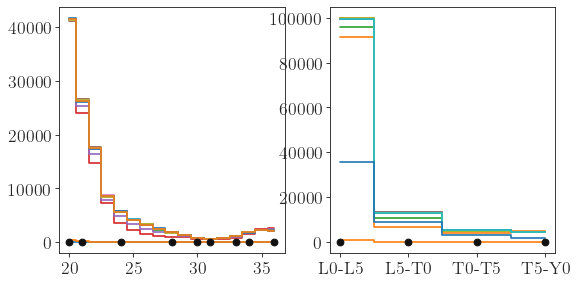

In [31]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(8, 4))

ax.step(spgrid, interlf*volumes*norm ,label=r'$\Phi$',  where='mid')
ax.step(spgrid, interdeslf*volumes, label=r'DES $\Phi$', where='mid')
ax.errorbar(spgrid, nobs, color='#111111' ,  yerr=np.sqrt(nobs), label='observations',fmt='o')

for idx in np.arange(10):
    #print ((other_lfs['spts'][idx]).shape)
    n0=drop_nan(other_lfs['spts'][idx][:,0])
    #print (len(n0))
    npred=np.histogram(n0, bins=len(spgrid))[0]*other_lfs['norm']*volumes
    ax.step(spgrid,npred, where='mid')
    ax1.step(spgrid2, bin_by_spt_bin(spgrid,npred),  where='mid',)
    
#ax1.set_yscale('log')
#ax.set_yscale('log')
ax1.errorbar(spgrid2, n2, color='#111111' ,  yerr=np.sqrt(n2), label='observations',fmt='o')
ax1.step(spgrid2, bin_by_spt_bin(spgrid,interlf*volumes), label=r'$\Phi$',  where='mid',)
ax1.step(spgrid2, bin_by_spt_bin(spgrid,interdeslf*volumes), label=r'DES $\Phi$', where='mid')

#plt.legend()

In [25]:
#(600*u.arcmin**2).to(u.deg**2)

In [27]:
other_lfs['norm']

8.334596150931958e-07